# Problem Statement
Predict the prices of houses in Mumbai

## Importing The Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
import category_encoders as ce
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import StandardScaler
from joblib import parallel_backend
from ray.util.joblib import register_ray
register_ray()
import warnings
warnings.filterwarnings('ignore')

In [3]:
df1 = pd.read_csv('MumbaiHousePrices.csv')

Reading the dataset

In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6347 entries, 0 to 6346
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Unnamed: 0            6347 non-null   int64 
 1   Price                 6347 non-null   int64 
 2   Area                  6347 non-null   int64 
 3   Location              6347 non-null   object
 4   No. of Bedrooms       6347 non-null   int64 
 5   New/Resale            6347 non-null   int64 
 6   Gymnasium             6347 non-null   int64 
 7   Lift Available        6347 non-null   int64 
 8   Car Parking           6347 non-null   int64 
 9   Maintenance Staff     6347 non-null   int64 
 10  24x7 Security         6347 non-null   int64 
 11  Children's Play Area  6347 non-null   int64 
 12  Clubhouse             6347 non-null   int64 
 13  Intercom              6347 non-null   int64 
 14  Landscaped Gardens    6347 non-null   int64 
 15  Indoor Games          6347 non-null   

In [5]:
df2 = df1.drop(columns = 'Unnamed: 0')

The dataset has an extra column that is not required. Hence it was removed

In [6]:
df2['Location'] = df2['Location'].str.strip()

Removing the whitespaces around the Location names

In [7]:
df2.groupby('Location')['Location','Price'].agg('mean').sort_values(by='Price',ascending=False)

,Price
Location,
Worli South Mumbai,233250000.0
juhu tara,180000000.0
Hanuman Nagar,165000000.0
worli sea Fase,153600000.0
Yari Road,122500000.0
...,...
ulhasnagar 4,2050000.0
Asangaon,2035000.0
Vasind,2000000.0


The Locations with the highest average property prices were in Worli, Hanuman Nagar, Yari Road, Breach Candy and Tardeo. For Worli the average house price was a whopping 2.3 crores

<AxesSubplot:>

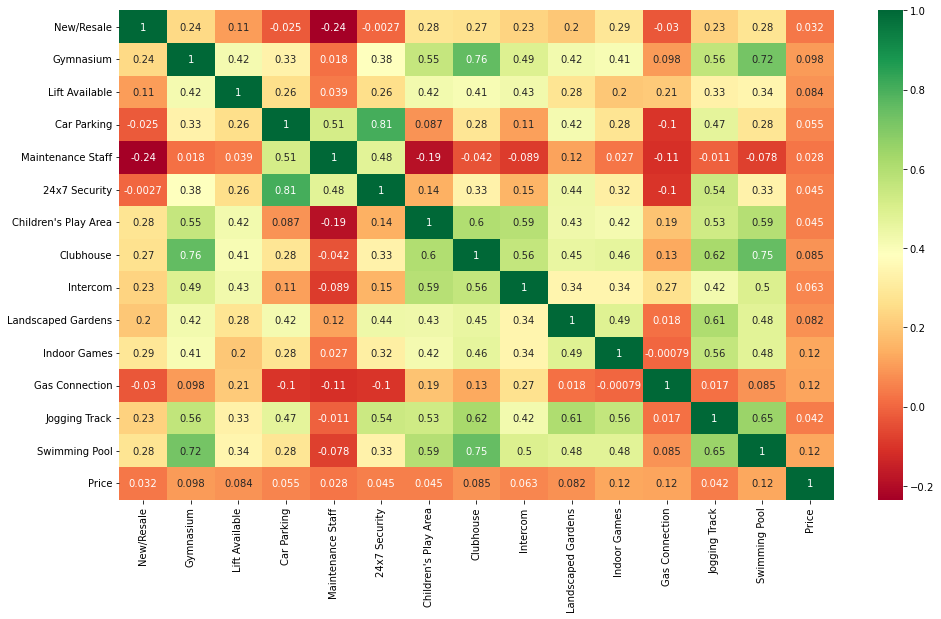

In [8]:
import seaborn as sns
plt.figure(figsize = (16,9))
sns.heatmap(df2.iloc[:,4:].join(df2['Price']).corr(),cmap='RdYlGn',annot = True)

From the above heatmap we can observe that none of the Boolean columns are correlated with price. The highest correlation is a measly 0.12. Hence it is better to remove those columns

In [9]:
df3 = df2.iloc[:,:4]
df3.head()

,Price,Area,Location,No. of Bedrooms
0,4850000,720,Kharghar,1
1,4500000,600,Kharghar,1
2,6700000,650,Kharghar,1
3,4500000,650,Kharghar,1
4,5000000,665,Kharghar,1


In [10]:
tenc=ce.TargetEncoder() 
df_Location=tenc.fit_transform(df3['Location'],df3['Price'],smoothing = 10)
df_Location.rename(columns = {'Location':'Location_Encoded'},inplace = True)
df4 = df3.join(df_Location)
df4.head()

,Price,Area,Location,No. of Bedrooms,Location_Encoded
0,4850000,720,Kharghar,1,1.045626e+07
1,4500000,600,Kharghar,1,1.045626e+07
2,6700000,650,Kharghar,1,1.045626e+07
3,4500000,650,Kharghar,1,1.045626e+07
4,5000000,665,Kharghar,1,1.045626e+07


We are going to use Target Encoder to convert the Categorical Location column into a numeric column. In this we calculate the mean of the Prices for that particular location and that value is considered to be our new Location value for that row. Here we are creating a new row itself called Location_Encoded which will store the new values and we for now keep the Location column.

In [11]:
df4['Price_per_sqft'] = df4['Price']/df4['Area']

In [12]:
def removeOutliners(df):
    df_Out = pd.DataFrame()
    for key,subdf in df.groupby('Location'):
        m = np.mean(subdf.Price_per_sqft)
        st = np.std(subdf.Price_per_sqft)
        reduced = subdf[(subdf.Price_per_sqft>(m-(st*3))) & (subdf.Price_per_sqft<=(m+(st*3)))] #Only rows with a price within 3 standard deviations from the mean for a particular location are retained. 
        df_Out = pd.concat([df_Out,reduced],ignore_index=True)
    return df_Out
df5 = removeOutliners(df4)
df5.shape

(6122, 6)

We create a new feature called Price_per_sqft and then use it to remove outliers according to their location. The method of outlier removal used was 3 sigma.

<AxesSubplot:>

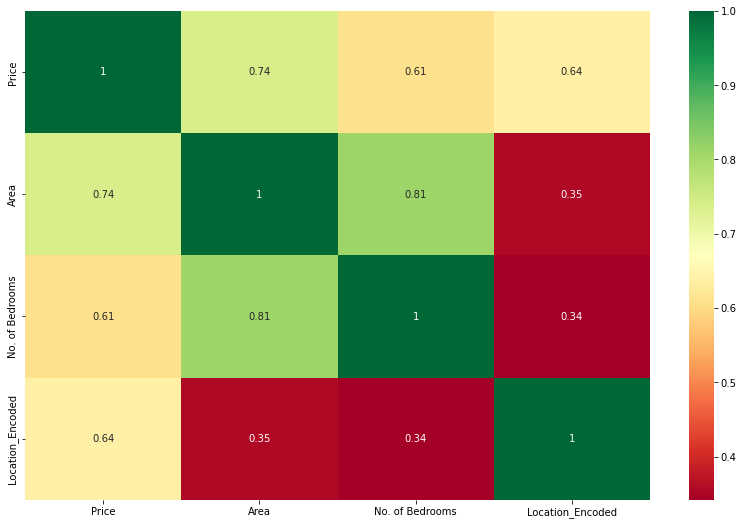

In [13]:
plt.figure(figsize=(14,9))
sns.heatmap(df5.drop(['Location','Price_per_sqft'],axis=1).corr(),cmap='RdYlGn',annot=True)

We can see that all of the features that we are going to use for our model training are highly correlated with our target feature.

In [14]:
X = df5.drop(['Price','Location','Price_per_sqft'],axis = 1)
y = np.log(df5['Price'])

We apply a log transform to the Price feature to make it more normalized.

In [15]:
def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse','squared_error'],
                'splitter': ['best','random']
            }
        },
        'gradient_booster': {
            'model': GradientBoostingRegressor(),
            'params': {
                'loss': ['squared_error', 'absolute_error'],
                'learning_rate': [0.1,1,1.5,2],
                'n_estimators': [10,50,100,150,200],
                'criterion': ['friedman_mse', 'squared_error']
            }
        },
        'ada_booster': {
            'model': AdaBoostRegressor(),
            'params': {
                'n_estimators': [10,50,100,150,200],
                'learning_rate': [0.1,1,1.5,2],
                'loss': ['linear','square','exponential']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        with parallel_backend('ray'): # We are using multithreading to speed up the process of training our models.
            gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

best_model = find_best_model_using_gridsearchcv(X,y)
print(best_model.head(5))

2023-05-18 19:01:57,298	INFO worker.py:1625 -- Started a local Ray instance.
2023-05-18 19:01:59,946	WARNING pool.py:588 -- The 'context' argument is not supported using ray. Please refer to the documentation for how to control ray initialization.
(PoolActor pid=12456) C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
(PoolActor pid=12456) If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:
(PoolActor pid=12456) 
(PoolActor pid=12456) from sklearn.pipeline import make_pipeline
(PoolActor pid=12456) 
(PoolActor pid=12456) model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())
(PoolActor pid=12456) 
(PoolActor pid=12456) If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:
(PoolActor pid=12456) 
(PoolActor pid

               model  best_score  \
0  linear_regression    0.774368   
1              lasso    0.714104   
2      decision_tree    0.880623   
3   gradient_booster    0.919665   
4        ada_booster    0.822554   

                                         best_params  
0                                {'normalize': True}  
1                {'alpha': 2, 'selection': 'cyclic'}  
2  {'criterion': 'squared_error', 'splitter': 'ra...  
3  {'criterion': 'friedman_mse', 'learning_rate':...  
4  {'learning_rate': 1, 'loss': 'exponential', 'n...  


We use Grid Search to find the best model and its parameters. From our training it looks like Gradient Boosting Regressor is the one with the best score.